# Fast Gradient Sign Method (FGSM)
\
$\eta = \epsilon \, \mathrm{sign}(\nabla_x L(\theta, x, y))$ <br>

$\eta \ldots$ perturbation <br>
$\epsilon \ldots$ maximal perturbation, i.e. $||\eta||_\infty \le \epsilon$ <br>
$x \ldots$ input <br>
$y \ldots$ target <br>
$\theta \ldots$ parameters <br>
$L \ldots$ loss function

In [75]:
import torch, pickle, argparse
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet
from data_loader import load_train_data, load_test_data
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfFastGradientAttack

In [2]:
filename = 'first_tests.pickle'

with open(filename, 'rb') as file:
    loaded = pickle.load(file)
    
data = np.array(loaded[0][0]).reshape(3,6,3,2)
hparams = argparse.Namespace(**data[2,-1,1,1])

In [3]:
TEST_PATH = "s2_mnist.gz"
# TRAIN_PATH = "s2_mnist_train_dwr_600000.gz"

# This model has been trained with 600k training samples, but the training data is not used,
# so we choose the smallest training set here.
TRAIN_PATH = "s2_mnist_train_dwr_10000.gz"

train_data = load_train_data(TRAIN_PATH)
test_data = load_test_data(TEST_PATH)

In [4]:
model = ConvNet(hparams, train_data, test_data).eval()
trainer = pl.Trainer(gpus=1, logger=False)
best_model = torch.load('checkpoints/epoch=17_v6.ckpt')
model.load_state_dict(best_model['state_dict'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<All keys matched successfully>

In [5]:
fmodel = PyTorchModel(model, bounds=(0, 255))
model = model.cpu()

images = test_data[:1000][0]#.cuda()
labels = test_data[:1000][1]#.cuda()
images = ep.astensor(images)
labels = ep.astensor(labels)

In [30]:
clean_accuracy = accuracy(fmodel, images[:1000], labels[:1000])

In [36]:
attack = LinfFastGradientAttack(random_start=False)
epsilons = [0.1, 0.5, 1, 5, 10, 20, 30, 50, 80, 100]

raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

In [37]:
success_rate = success.float32().mean(axis=-1)

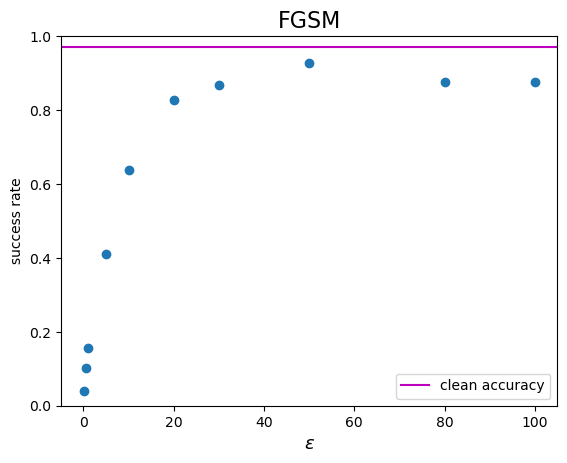

In [38]:
fontsize=13
plt.plot(epsilons, success_rate.raw, 'o')
plt.title('FGSM', fontsize=16)
plt.xlabel(r'$\epsilon$', fontsize=13)
plt.ylabel('success rate')
plt.ylim([0,1])
plt.axhline(clean_accuracy, color='m', label='clean accuracy')
plt.legend()
# plt.xscale('log')
plt.show()

In [39]:
robust_accuracy = 1 - success.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.1   : 96.1 %
  Linf norm ≤ 0.5   : 89.9 %
  Linf norm ≤ 1     : 84.3 %
  Linf norm ≤ 5     : 59.0 %
  Linf norm ≤ 10    : 36.2 %
  Linf norm ≤ 20    : 17.3 %
  Linf norm ≤ 30    : 13.2 %
  Linf norm ≤ 50    :  7.2 %
  Linf norm ≤ 80    : 12.4 %
  Linf norm ≤ 100   : 12.5 %


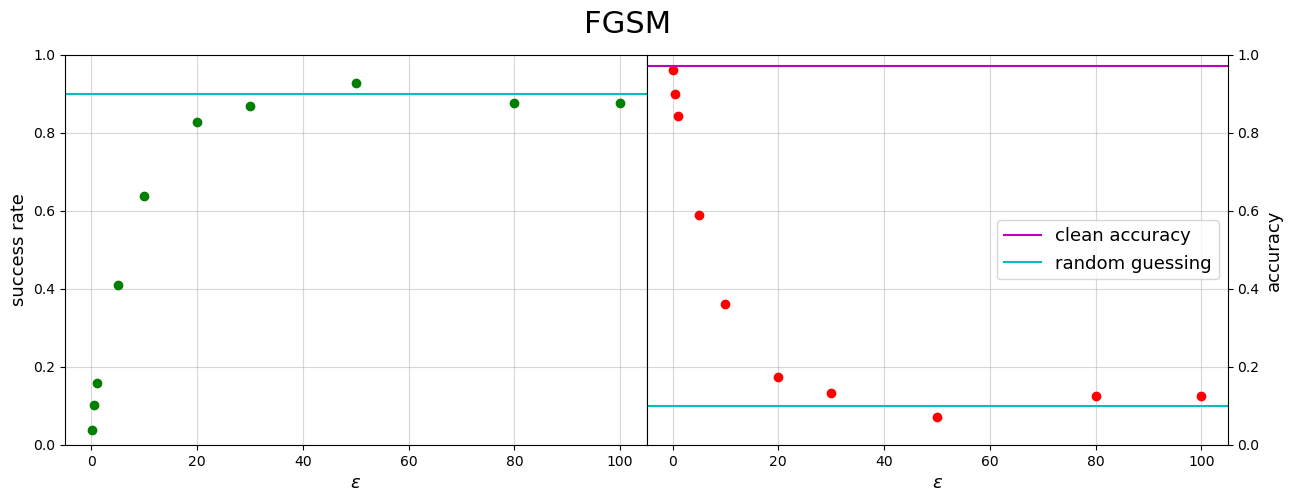

In [78]:
fontsize = 13

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15, 5), gridspec_kw = {'wspace':0., 'hspace':0.})
fig.suptitle('FGSM', fontsize=22)
plt.subplots_adjust(top=0.89)
axs[0].plot(epsilons, success_rate.raw, 'og')
axs[0].set_ylabel('success rate', fontsize=fontsize)
axs[0].axhline(y=0.9, color='c')
axs[1].plot(epsilons, robust_accuracy.raw, 'or')
axs[1].axhline(y=clean_accuracy, color='m', label='clean accuracy')
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylabel('accuracy', fontsize=fontsize)
axs[1].axhline(y=0.1, color='c', label='random guessing')
for j in range(2):
    axs[j].set_xlabel(r'$\epsilon$', fontsize=fontsize)
    axs[j].set_ylim([0,1])
    axs[j].grid(alpha=0.5)

axs[1].legend(fontsize=fontsize)

plt.show()